# Imports

In [1]:
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.metrics import make_scorer, roc_auc_score
auc = make_scorer(roc_auc_score)
# from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.experimental import enable_halving_search_cv # noqa
import warnings
warnings.filterwarnings("ignore")
import pickle

# Data Preprocessing

### Variable Initialization

In [2]:
#start and end working hours
start_h = 7
end_h = 18
friday = 4
# Features we would like to min-max scale
scale_cols = ['Temperature', 'Humidity','Light', 'CO2']
# Features we don't want to pass to the model
exclude_cols = ['Occupancy', 'date', 'HumidityRatio']

In [3]:
# loading data
train = pd.read_csv("datatraining.txt")
train['date'] = pd.to_datetime(train['date'])
test1 = pd.read_csv("datatest.txt")
test1['date'] = pd.to_datetime(test1['date'])
test2 = pd.read_csv("datatest2.txt")
test2['date'] = pd.to_datetime(test2['date'])
test = pd.concat([test1, test2])

train['Occupancy'] = train['Occupancy'].astype("category")
test['Occupancy'] = test['Occupancy'].astype("category")

In [4]:
# It's important to scale the features from 0 to 1 so the learning is easier.  
# We don't need to do the other classes as they are not used in training
scaler = MinMaxScaler()

scaler.fit(np.array(train[scale_cols]))
#Save the file using pickel, 
pickle.dump(scaler, open('feature_scaler.sav', 'wb'))
train[scale_cols] = scaler.transform(np.array(train[scale_cols]))
test[scale_cols] = scaler.transform(np.array(test[scale_cols]))

In [5]:
train.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,0.387341,0.401676,0.077292,0.119942,0.003863
std,0.243281,0.247233,0.125947,0.194536,0.000852
min,0.000000,0.000000,0.000000,0.000000,0.002674
25%,0.167464,0.154431,0.000000,0.016246,0.003078
50%,0.332536,0.423623,0.000000,0.025220,0.003801
75%,0.571770,0.616307,0.165795,0.139925,0.004352
max,1.000000,1.000000,1.000000,1.000000,0.006476


# Adding a helper variables

We have additional knowledge about the enviornment, and quite often if we can feed in helpful information to our models, we can assist the learning. In our case we know when the work days begin and end.  So we will create a boolean variable that indicates if its working time or not.

First generate masks

In [19]:
# Train and test masks which allow for selection of: week days and working hours
wd_mask          = train['date'].dt.weekday <= friday
wd_mask_test     = test['date'].dt.weekday <= friday
wh_mask_tmp      = np.logical_and(train['date'].dt.hour <= end_h, train['date'].dt.hour >= start_h)
wh_mask_test_tmp = np.logical_and(test['date'].dt.hour <= end_h, test['date'].dt.hour >= start_h)

wh_mask      = np.logical_and(wh_mask_tmp , wd_mask)
wh_mask_test = np.logical_and(wh_mask_test_tmp, wd_mask_test)

create columns

In [7]:
train['Work-hour'] = wh_mask.astype(int)
train['Work-hour'] = train['Work-hour'].astype("category")

test['Work-hour'] = wh_mask_test.astype(int)
test['Work-hour'] = test['Work-hour'].astype("category")

Create dataset only with work days and work hours

In [20]:
train_wd = train[wd_mask]
train_wh = train[wh_mask]

# Ballancing Classes

Class imballance is a problem and needs to be dealt with.  We can under sample the majority class or over sample the minority dataset. Considering the low number of training samples, we will stick with oversampling the class minority class.

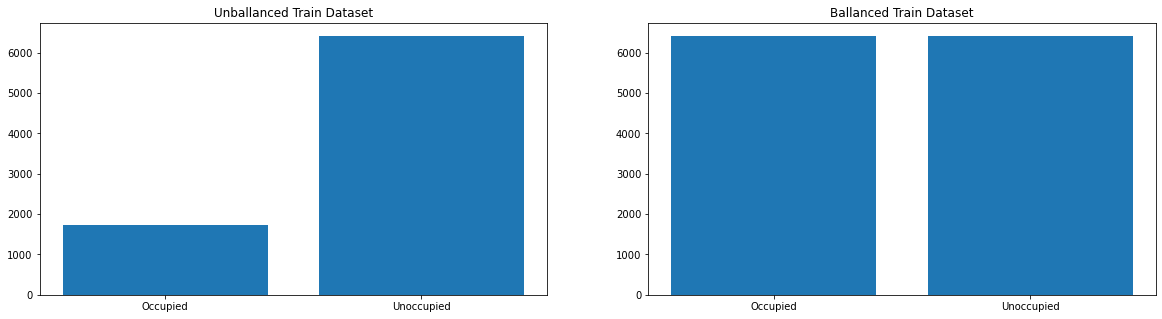

In [9]:
num_Nooccupided=np.sum(train['Occupancy'] == 0)
num_occupied = np.sum(train['Occupancy'] == 1)
num_Nooccupided,num_occupied = train['Occupancy'].value_counts()

train_occupied, train_Nooccupided = train[train['Occupancy'] == 1], train[train['Occupancy'] == 0]
train_occupied_sampled = train_occupied.sample(num_Nooccupided, replace=True)
train_ballanced = pd.concat([train_occupied_sampled, train_Nooccupided], axis=0)
counts = train_ballanced['Occupancy'].value_counts()

fig, axs = plt.subplots(1, 2,figsize=(20,5))
axs[0].bar(['Occupied','Unoccupied'],[num_occupied, num_Nooccupided])
axs[0].set_title('Unballanced Train Dataset')
axs[1].bar(['Occupied','Unoccupied'],[counts[0],counts[1]])
axs[1].set_title('Ballanced Train Dataset')
plt.show()

## Baseline

The **baseline** represents a simple program that would looks at the current hour, and turn on the HVAC if the time is between 7 to 7pm (working hours). Therefore if we use this 

In [10]:
# Monday is represented as 0, and Friday is 4.
b_mask_end   = test['date'].dt.hour <= end_h
b_mask_start = test['date'].dt.hour >= start_h
b_mask_day   = test['date'].dt.weekday <= friday
baseline_mask = b_mask_day * b_mask_start * b_mask_end
baseline = metrics.accuracy_score(test.Occupancy, baseline_mask.astype(int))
print('Test Accuracy for Naieve guessing during Work hours : ', baseline*100)

Test Accuracy for Naieve guessing during Work hours :  0.881130707900459


If we use this simple logic we can get roughly **88%** accuracy

It is also helpful to look only at the difficult timeframes (during working hours). We would only have to guess with 100% occupied during this time frame

In [11]:
test_realworkhours = test[baseline_mask]
naieve_guess_realworkhours = np.ones(len(test_realworkhours)).reshape(-1,1)
baseline_wh = metrics.accuracy_score(test_realworkhours.Occupancy, naieve_guess_realworkhours)
print('Test Accuracy for Naieve guessing during Work hours : ', baseline_wh)

Test Accuracy for Naieve guessing during Work hours :  0.6717811874583055


So while the overall accuracy of our naieve implementation is roughly **88%**, it's important to know that accuracy during working hours is really **67%**.  This number would be even lower when considering holidays.

## Train and Testing

By default SGDClassifier uses a SVM model, but trains using small batches. Many other models were considered including: Decision Tree, SVM without SGD, a MLP.  SVM with SGD is shown here becuase it was the best performing model.

In [23]:
sgdm = SGDClassifier(loss="hinge", penalty="l1", max_iter=10000) # 
sgdm.fit(train_ballanced.drop(columns = exclude_cols), train_ballanced['Occupancy'])
sgdm_full_pred = sgdm.predict(test.drop(columns = exclude_cols))
accuracy = metrics.accuracy_score(test.Occupancy, sgdm_full_pred) 

sgdm_aab = (accuracy - baseline) * 100
print("\tTest Accuracy:",accuracy * 100)
print("\tTest Accuracy above baseline :",sgdm_aab)
pickle.dump(sgdm, open('hvac_model.sav', 'wb'))

	Test Accuracy: 99.0980107916566
	Test Accuracy above baseline : 10.984940001610699


In [33]:
sgdm = SGDClassifier(loss="hinge", penalty="l1", max_iter=10000) # 
sgdm.fit(train.drop(columns = exclude_cols), train['Occupancy'])
sgdm_full_pred = sgdm.predict(test.drop(columns = exclude_cols))
accuracy = metrics.accuracy_score(test.Occupancy, sgdm_full_pred) 

sgdm_aab = (accuracy - baseline) * 100
print("\tTest Accuracy:",accuracy * 100)
print("\tTest Accuracy above baseline :",sgdm_aab)
pickle.dump(sgdm, open('hvac_model.sav', 'wb'))

	Test Accuracy: 98.7919787388258
	Test Accuracy above baseline : 10.678907948779903


In [13]:
sgdm_diff_pred = sgdm.predict(test_realworkhours.drop(columns = exclude_cols))
diff_accuracy = metrics.accuracy_score(test_realworkhours.Occupancy, sgdm_diff_pred) 

sgdm_aab_diff = (diff_accuracy - baseline_wh) * 100
print("\tWork Hours Test Accuracy:",diff_accuracy * 100)
print("\tWork Hours Test Accuracy above baseline :",sgdm_aab_diff)
pickle.dump(sgdm, open('hvac_model.sav', 'wb'))

	Work Hours Test Accuracy: 97.50945074494108
	Work Hours Test Accuracy above baseline : 30.33133199911052


In [14]:
# Save the model for the cloud solution
filename = 'hvac_model.sav'
pickle.dump(sgdm, open(filename, 'wb'))

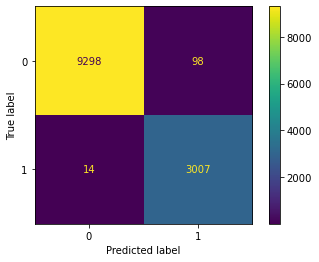

In [15]:
ConfusionMatrixDisplay.from_predictions(test.Occupancy, sgdm_full_pred)
plt.show()

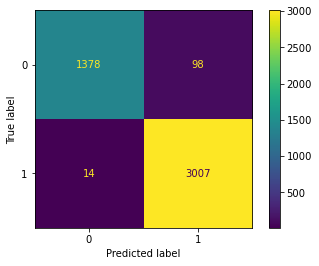

In [16]:
ConfusionMatrixDisplay.from_predictions(test_realworkhours.Occupancy, sgdm_diff_pred)
plt.show()

# Curve to see how much more data collection is needed.

In [25]:
occ_subset = train_ballanced[train_ballanced.Occupancy == 1]
unocc_subset = train_ballanced[train_ballanced.Occupancy == 0]

In [31]:
accuracies = []
for i in np.arange(0.001,1,0.001):
    xy_occ = occ_subset.sample(frac=i, replace=False)
    xy_unocc = unocc_subset.sample(frac=i, replace=False)
    x = pd.concat([xy_occ.drop(columns = exclude_cols), xy_unocc.drop(columns = exclude_cols)])
    y = pd.concat([xy_occ.Occupancy, xy_unocc.Occupancy])
    
    model = SGDClassifier(loss="hinge", penalty="l1", max_iter=10000) # 
    model.fit(x,y)
    svmm_full_pred = model.predict(test.drop(columns = exclude_cols))
    score = metrics.accuracy_score(test.Occupancy, svmm_full_pred)
    # print("\tTest Accuracy all  :",score)
    accuracies.append(score)

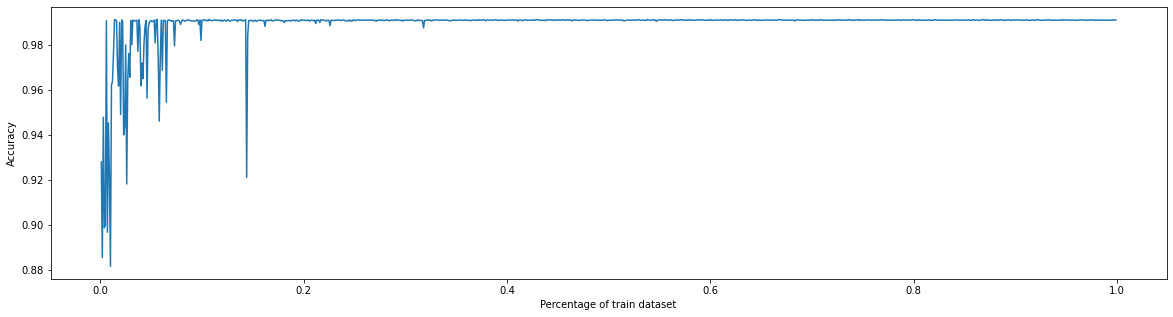

In [32]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0.001,1,0.001),accuracies)
plt.xlabel('Percentage of train dataset')
plt.ylabel('Accuracy')
plt.show()

It appears that increasing the data would not greatly improve our model, but this is also a bit misleading!